In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('modules')
import numpy as np
from numpy import sum, exp, pi, asarray

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy import units as u

from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

import pandas as pd

import healpy as hp

from calculations_module import *
# from cosmology_module import Cosmology_function
# from variance_module import Variance
# from ratefunction_module import *
from criticalpoints_module import *
from computePDF_module import *
from variables_module import *

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import os

Calculate effective redshifts for each bin in cosmoGRID

In [7]:
for i in range(1, 5):
    nz = np.loadtxt(f'/feynman/home/dap/lcs/at278006/work/l1_theory_validation/cosmogrid_nz/nz_stage3_{i}.txt')
    z_vals = nz[:,0]
    n_vals = nz[:,1]
    n_norm = n_vals / np.trapezoid(n_vals, z_vals)  # normalize
    z_eff = np.trapezoid(z_vals * n_norm, z_vals)
    print(f"Effective source redshift for stage 3, bin {i} =", z_eff)

Effective source redshift for stage 3, bin 1 = 0.308171211419312
Effective source redshift for stage 3, bin 2 = 0.48443532685546886
Effective source redshift for stage 3, bin 3 = 0.7545171189406666
Effective source redshift for stage 3, bin 4 = 0.9416943189728402


The steps involved are as follows:

Step 1: Get the cosmological parameters

Step 2: Calculate the rate function and find the critical points

Step 3: Calculate the scaled CGF

step 4: Apply inverse lalpace transform on this to get the PDF

In the below code the critical points could be plotted if needed and the SCGf could also be plotted if needed by seeting the corresponding flags.

The l1 is obtained from the simulation PDF

In [5]:
#######
# cosmoGRID simulation parameters
#######
h = 0.673
Ob = 0.0493
Oc = 0.2107
mnu = 0.0
Om = Ob + Oc
ns = 0.9649
As_ = 2.10
# As = As_ * 1e-9
Omnu = mnu / 93.14 / h / h
Ol = 1.0 - Om
Oc = Om - Ob - Omnu
H0 = 100.
speed_light = 299792.458

zs = 0.95 # approximate redshift of the 4th bin
theta1_input = 15.

nz_file_path = '/feynman/home/dap/lcs/at278006/work/l1_theory_validation/cosmogrid_nz/nz_stage3_4.txt'

print("Loading parameters..")
# Initialize variables for simulation
variables = VariablesGenerator(h, H0, Ob, Oc, mnu, ns, As_, zs, theta1_input)

Loading parameters..
the source redshift is:  0.95
the chistar is:  2279.55770232557
the number of planes being used is:  21
The mass map variance from theory is:  5.281272189849446e-06


In [7]:
# Flag to load CosmoGRID simulation data
load_cosmogrid = True
if load_cosmogrid:
    print("\nNow computing for the CosmoGRID simulation..")
    from cosmogrid_loader import CosmoGridLoader  # Make sure this module is accessible.
    
    # CosmoGRID maps are at nside=512, and we use the same smoothing logic.
    loader = CosmoGridLoader(nside_target=512)
    
    # 'theta' is your smoothing scale in arcmin; id_zbin is the desired redshift bin.
    variance_cosmogrid, kmap1, kmap2 = loader.run_loader(theta=theta1_input, id_zbin=3, perm_index=0, nprocess=1)
    
    # Compute the mass map difference (smoothed with 2θ vs. θ)
    k_massmap_simulation = kmap2 - kmap1
    variables.recal_value = variables.sigmasq_map / variance_cosmogrid
    print("The driving parameter is:", variables.recal_value)
    
    # Calculate the PDF of the simulation
    pdf_simulation, bin_edges = np.histogram(k_massmap_simulation, bins=300, density=True)
    kappa_sim = 0.5 * (bin_edges[:-1] + bin_edges[1:])


Now computing for the CosmoGRID simulation..
Assumed source redshift (mean n(z)): 0.95
The driving parameter is: 0.7389306292120185


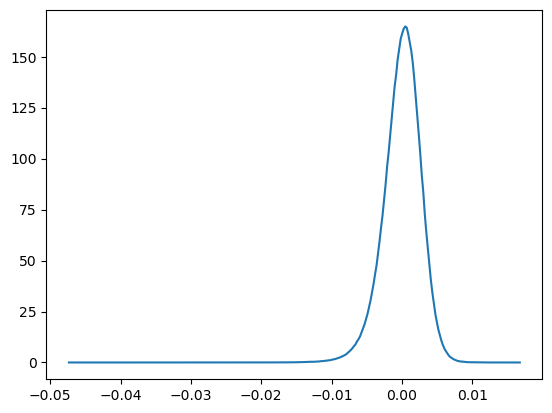

In [8]:
# plot the pdf
plt.plot(kappa_sim, pdf_simulation)

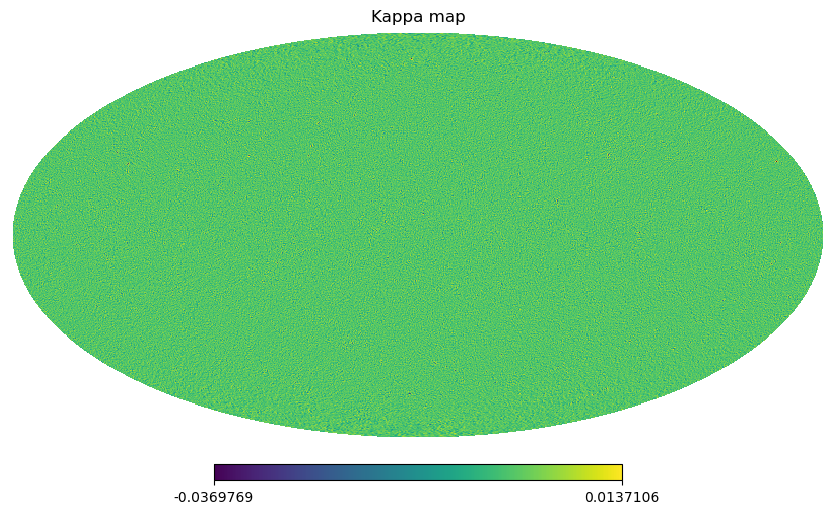

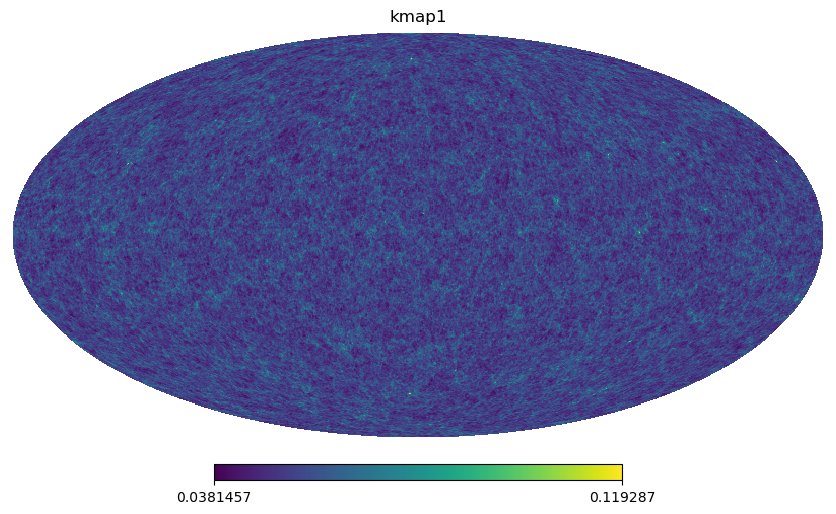

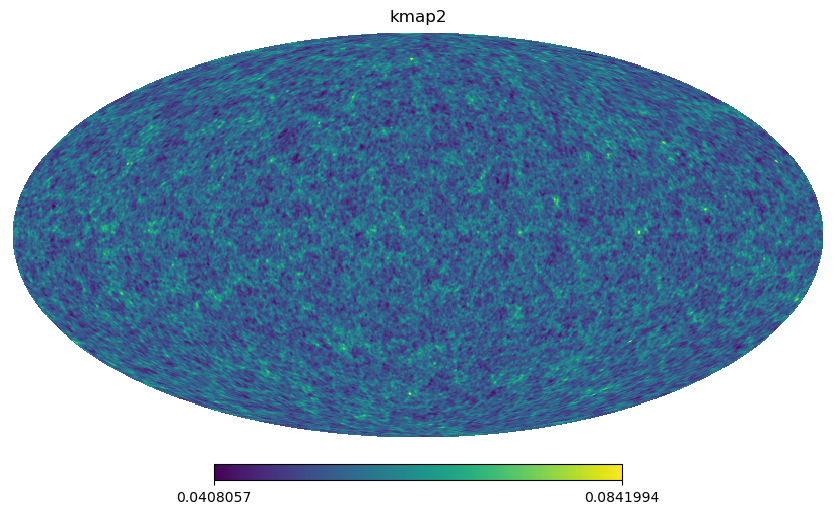

In [11]:
hp.mollview(k_massmap_simulation, title='Kappa map')
plt.show()
hp.mollview(kmap1, title='kmap1')
plt.show()
hp.mollview(kmap2, title='kmap2')
plt.show()

Calculating the critical points in each plane..
Setting ngrid = 100. Increase this for more accuracy, but note that computation becomes slower!
The approximate critical points at redshift z:  0.02  are:  [1627.39571287 -786.53794076]
The approximate critical points at redshift z:  0.04  are:  [1239.89836021 -628.11881301]
The approximate critical points at redshift z:  0.06  are:  [1132.59246238 -599.83630448]
The approximate critical points at redshift z:  0.08  are:  [1098.93684045 -598.32975768]
The approximate critical points at redshift z:  0.1  are:  [1092.20722314 -603.19401182]
The approximate critical points at redshift z:  0.12  are:  [1099.63328739 -610.40607592]
The approximate critical points at redshift z:  0.14  are:  [1115.44331639 -618.48221128]


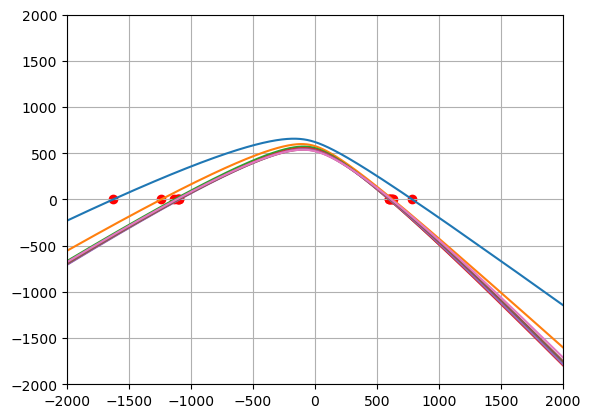

Smallest pair(s) of critical points are: (array([1098.93684045, -598.32975768]), array([1092.20722314, -603.19401182]))
 


In [12]:
print("Calculating the critical points in each plane..")
criticalpoints = CriticalPointsFinder(variables, ngrid=100, plot=True)
critical_values = []
for i in range(1,8):
    critical_values.append(criticalpoints.get_critical_points(1*i*0.02))
plt.show()
critical_values = np.array(critical_values)
smallest_pair = find_smallest_pair(critical_values)
print("Smallest pair(s) of critical points are:", smallest_pair)
# plt.plot(critical_values[:,0],critical_values[:,1])

print(" ")

In [13]:
print("Getting the PDF..")
# variables.lambdas = np.linspace(smallest_pair[0][1]+30, smallest_pair[0][0]-100, 20)
variables.lambdas = np.linspace(-500, 600, 20)
computed_PDF = computePDF(variables, plot_scgf=False)
pdf_values, kappa_values = computed_PDF.pdf_values, computed_PDF.kappa_values

pdf_spline = CubicSpline(kappa_values,pdf_values)
pdf_theory = pdf_spline(kappa_sim)

l1_pred = get_l1_from_pdf(pdf_theory, kappa_sim)
l1_sim = get_l1_from_pdf(pdf_simulation, kappa_sim)

Getting the PDF..
7.147187644531837e-06809524 %%


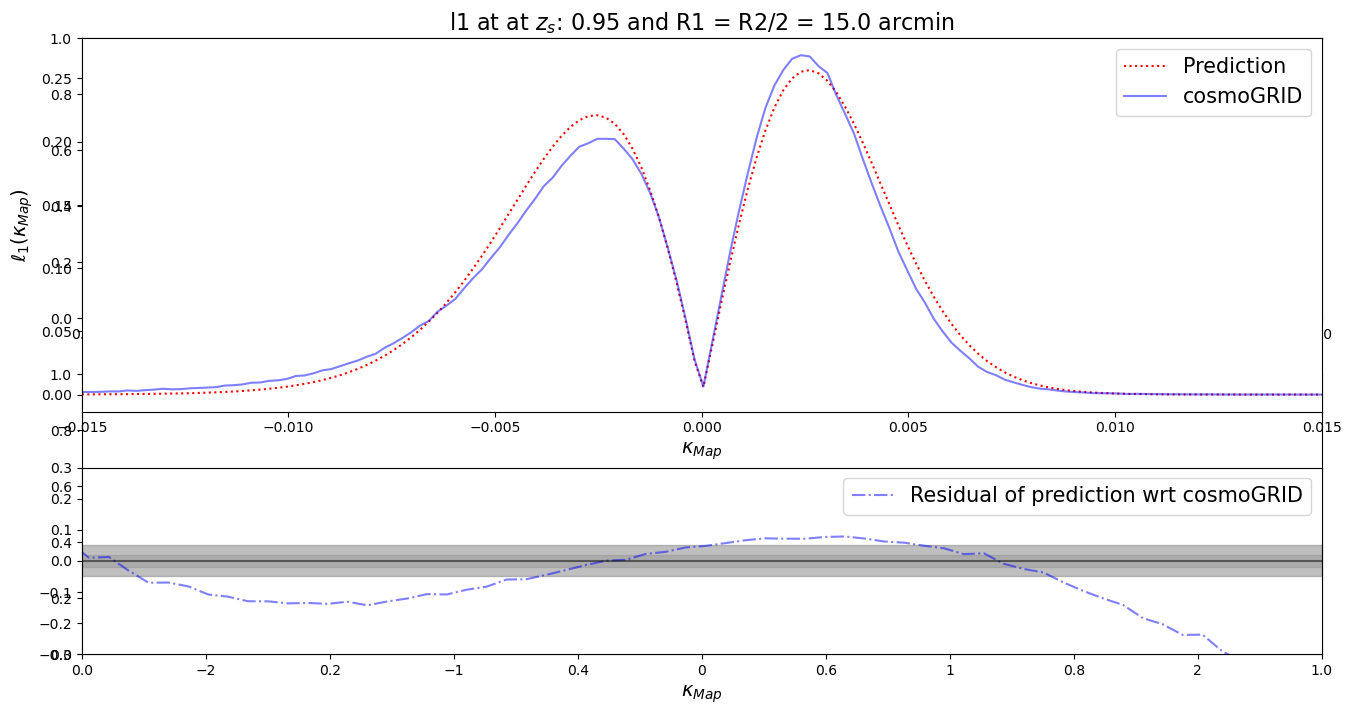

In [18]:
fig, axs = plt.subplots(2,1, figsize=(16,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

plt.subplot(gs[0, 0])
plt.plot(kappa_sim,l1_pred, ls=":", c='r', label='Prediction')
plt.plot(kappa_sim, l1_sim, label="cosmoGRID",c='b', alpha=0.5)
# plt.yscale('log')
plt.legend()
plt.xlabel(r'$\kappa_{Map}$', size = 14)
plt.ylabel(r'$\ell_1(\kappa_{Map})$', size = 14)
plt.legend(fontsize=15)
plt.xlim(-0.015,0.015)
# plt.title(r"l1 at at $z_s$: " + str(zs) + " and R1 = R2/2 = " + str(theta1_input) + " arcmin" , fontsize=16)
plt.title(r"l1 at at $z_s$: " + str(zs) + " and R1 = R2/2 = " + str(theta1_input) + " arcmin" , fontsize=16)

xlim_min = -0.0125
xlim_max = 0.008

plt.subplot(gs[1, 0])
plt.plot(kappa_sim/np.sqrt(variance_cosmogrid), (l1_sim-l1_pred)/l1_sim, label="Residual of prediction wrt cosmoGRID", ls="-.",c='b', alpha=0.5)
plt.legend(fontsize=15)
plt.xlabel(r'$\kappa_{Map}$', size = 14)
# plt.ylabel(r'$\frac{P(\mathrm{\kappa_{Map}}) - P_{prediction}(\mathrm{\kappa_{Map}})}{P_{prediction}(\mathrm{\kappa_{Map}})}$', size=14)
plt.ylim(-0.30,0.30)
plt.axhline(0,0,1,color='k',alpha=0.5)
plt.axhspan(-0.02,0.02,0,1,alpha=0.3,color='grey')
plt.axhspan(-0.05,0.05,0,1,alpha=0.5,color='grey')
plt.xlim(-2.5,2.5)
plt.show()


In [16]:
# Calculate statistical moments
pred_stat = get_moments(kappa_sim, pdf_theory)
sim_stat = get_moments(kappa_sim, pdf_simulation)
# Compare prediction and simulation
data = {
"Metric": ["Mean", "Variance", "Skewness", "Kurtosis","Norm"],
"Prediction PDF": pred_stat,
"Simulation PDF": sim_stat,
}
df = pd.DataFrame(data)
print(df)

zs_formatted = str(zs).replace('.', '_')

# Format the filename to include zs and theta1_input
filename = f"theory_values_{zs_formatted}_{theta1_input}"

# Format the content to save the calculated values
content = f"""
Computed Values:
- L1 Prediction: {l1_pred}
- PDF Prediction: {pdf_theory}
- kappa: {kappa_sim}
"""
theory_data = np.array([pdf_theory, l1_pred, kappa_sim])

cwd = os.getcwd()
# Path to save the file
file_path = cwd+f"/paper/data/{filename}"
np.save(file_path, theory_data.T)

     Metric  Prediction PDF  Simulation PDF
0      Mean   -2.220806e-10   -3.748256e-08
1  Variance    7.147186e-06    7.150550e-06
2  Skewness   -9.087447e+01   -2.414602e+02
3  Kurtosis    3.436529e-01    2.235047e+00
4      Norm    1.000000e+00    9.999997e-01
